## Prepare


In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from transformers import ViTForImageClassification, ViTImageProcessor

/opt/homebrew/Caskroom/miniforge/base/envs/PBL/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess


In [2]:
MODEL_NAME = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(MODEL_NAME, local_files_only=True)
processor = ViTImageProcessor.from_pretrained(MODEL_NAME, local_files_only=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_augmentation = transforms.Compose(
    [
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ]
)

In [4]:
transform_train = transforms.Compose(
    [
        data_augmentation,
        transforms.ToTensor(),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
    ]
)
transform_test = transforms.Compose(
    [
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
    ]
)

## Load datasets


In [5]:
def load_datasets(root: str, batch_size: int = 32):
    def _load_dataset(
        subfolder: str, transform: transforms.Compose, shuffle: bool = False
    ):
        dataset = ImageFolder(root=os.path.join(root, subfolder), transform=transform)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return (
        _load_dataset("train", transform=transform_train, shuffle=True),
        _load_dataset("validate", transform=transform_test),
        _load_dataset("test", transform=transform_test),
    )

In [6]:
ROOT = "./dataset"
train_loader, validate_loader, test_loader = load_datasets(ROOT)

## Train


In [7]:
num_classes = 3
model.classifier = nn.Sequential(
    nn.Linear(in_features=768, out_features=512),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=256, out_features=num_classes),
)

In [8]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
NUM_EPOCHS = 10
losses = []
accuracies = []
for epoch in range(NUM_EPOCHS):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in validate_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracies.append(100 * correct / total)
    print(
        f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%"
    )
    scheduler.step()

    # Save checkpoint
    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "loss": losses[-1],
            },
            f"checkpoint_{epoch + 1}.pt",
        )

Epoch [1/10], Loss: 8.1212, Accuracy: 98.67%
Epoch [2/10], Loss: 6.0056, Accuracy: 100.00%
Epoch [3/10], Loss: 3.5502, Accuracy: 98.67%
Epoch [4/10], Loss: 1.5692, Accuracy: 100.00%
Epoch [5/10], Loss: 0.6343, Accuracy: 100.00%
Epoch [6/10], Loss: 0.6346, Accuracy: 100.00%
Epoch [7/10], Loss: 0.4748, Accuracy: 100.00%
Epoch [8/10], Loss: 0.8194, Accuracy: 100.00%
Epoch [9/10], Loss: 0.3039, Accuracy: 100.00%
Epoch [10/10], Loss: 0.2228, Accuracy: 100.00%


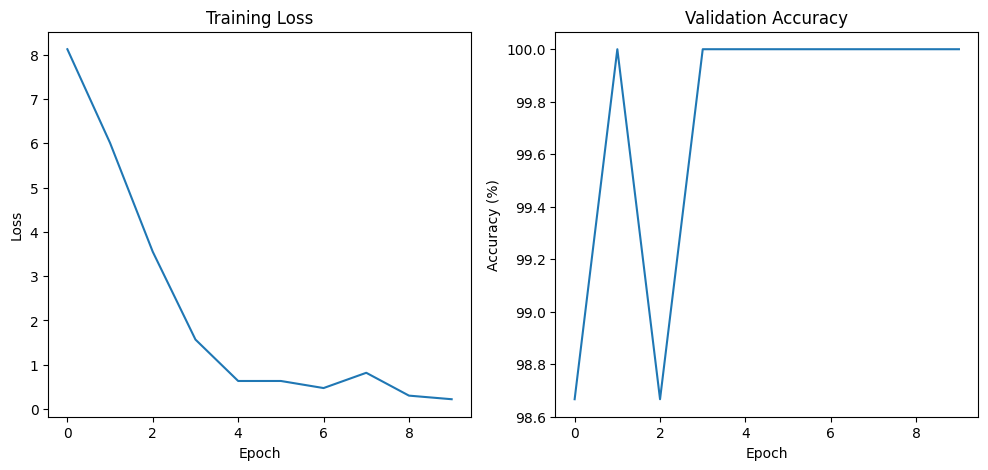

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()

## Test model


In [17]:
def test_checkpoint(dir: str):
    _checkpoint = torch.load(f=dir, map_location=device, weights_only=True)
    _model = ViTForImageClassification.from_pretrained(
        MODEL_NAME, local_files_only=True
    )
    _model.classifier = nn.Sequential(
        nn.Linear(in_features=768, out_features=512),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=512, out_features=256),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=256, out_features=num_classes),
    )
    _model.load_state_dict(_checkpoint["model_state_dict"])
    _model.to(device)

    _model.eval()
    _correct, _total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = _model(images).logits
            _, predicted = torch.max(outputs, 1)
            _total += labels.size(0)
            _correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * _correct / _total:.2f}%")

In [18]:
test_checkpoint("./checkpoint_10.pt")

Test Accuracy: 100.00%
